MongoDB Server Status

In [ ]:
import pymongo
from pymongo import MongoClient
from pprint import pprint

# Connect to MongoDB
client = pymongo.MongoClient(
    "mongodb://172.17.30.23:27017/", 
    serverSelectionTimeoutMS=3000, 
    username="sa", 
    password="global11!"
    )

# Get the database performance metrics
server_info = client.admin.command("serverStatus")

# Print the performance metrics
pprint(server_info)

MongoDB Top Queries

To verify that the system.profile collection is enabled in MongoDB 4.4, you can use the following steps:

Connect to your MongoDB instance:

> use <database_name>
Use the db.getProfilingStatus() method to get the current profiling status:

> db.getProfilingStatus()
Check the returned document for the profilingLevel field:

{
    "was" : 0,
    "slowms" : 100,
    "sampleRate" : 1,
    "level" : 0,
    "ns" : "test.coll"
}
If level is set to 0, the profiler is off and the system.profile collection is not being populated.
If level is set to 1, the profiler is logging slow operations and the system.profile collection may contain profile documents.
If level is set to 2, the profiler is logging all operations and the system.profile collection will contain profile documents for all operations.
If the system.profile collection is not enabled, you can enable it by setting the profiler level to 1 or 2 using the db.setProfilingLevel() method.


This will enable the profiler and start logging slow operations that executes more than 50ms to the system.profile collection:
> db.setProfilingLevel(1, { slowms: 50 })
{ was: 1, slowms: 50, sampleRate: 1, ok: 1 }

In [5]:
import pymongo
from pymongo import MongoClient
from pprint import pprint
import pandas as pd

# Connect to MongoDB
client = pymongo.MongoClient(
    "mongodb://172.17.30.23:27017/", 
    serverSelectionTimeoutMS=3000, 
    username="sa", 
    password="global11!"
    )

# Get the performance database
perf_db = client["test"]["system.profile"]

# Get the top 10 queries in the last 24 hours
import datetime
time_24hrs_ago = datetime.datetime.now() - datetime.timedelta(hours=24)

# List 5 top queries ($limit)
top_queries = perf_db.aggregate([
    {"$match": {"ts": {"$gt": time_24hrs_ago}}},
    {"$sort": {"millis": -1}},
    {"$limit": 10}
])

# Expand the cursor and construct the DataFrame
#df =  pd.DataFrame(list(top_queries))
#df

# Print full deatils of query one by one
for query in top_queries:
    print ("---------- New Query ---------------------------------")
    pprint(query)
    pprint("                                                      ")


MongoDB List Databases and Size

        database_name  sizeOnDisk
0         CETServices     1109.55
1            CETItems       71.58
2          MsActivity       21.24
3      learninglocker        3.85
4            CETTrees        1.38
5       CosmosCreator        0.68
6       ProductPlayer        0.25
7           MsCookies        0.17
8   MsRecommendations        0.11
9          CETFolders        0.02
15               test        0.01
10            CETLogs        0.00
11    CETProfiles-bzq        0.00
12              admin        0.00
13             config        0.00
14              local        0.00


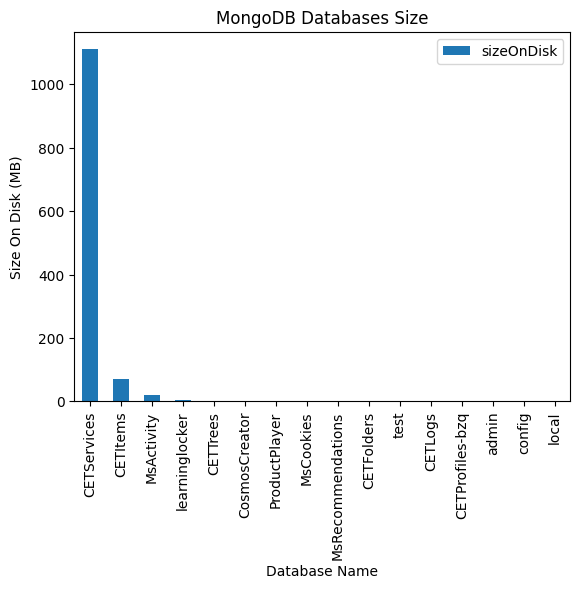

In [7]:
# Databases size bar graph from MongoDB
from pymongo import MongoClient
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from pprint import pprint

# MongoDB connection string
myClient = MongoClient(
    host='172.17.30.23:27017',
    serverSelectionTimeoutMS=3000,
    username="sa",
    password="global11!"
    )

# Set pandas dataframe with 2 columns
df = pd.DataFrame(columns=['database_name','sizeOnDisk'])

# Iterate over all databases and populate the dataframe
for dbname in enumerate(myClient.list_databases()):
    # print("database name is : ",dbname) # This is the original tupple
    database_name = dbname[1].get('name')
    size_on_disk  = dbname[1].get('sizeOnDisk')
    # print("database: ", database_name, ", Size: ", round(size_on_disk/1024/1024/1024,2), ' GB')
    
    # Populate the dataframe
    record = {'database': database_name, 'sizeOnDisk': size_on_disk }

    entry = pd.DataFrame.from_dict({
     "database_name": [database_name],
     "sizeOnDisk":  [round(size_on_disk/1024/1024/1024,2)]
    })


    df = pd.concat([df, entry], ignore_index=True).sort_values(by='sizeOnDisk', ascending=False)

# Display in grid using pandas
print(df)

# Display as graph
df.plot(x='database_name', y='sizeOnDisk', kind='bar', title='MongoDB Databases Size', xlabel='Database Name', ylabel='Size On Disk (MB)') 
plt.show()


MongoDB Error Log (from cache)

In [ ]:
import pymongo
from collections import defaultdict
import json
import pandas as pd
import pandasql as ps
import duckdb
from pprint import pprint

# Connect to MongoDB
client = pymongo.MongoClient(
    "mongodb://172.17.30.23:27017/", 
    serverSelectionTimeoutMS=3000, 
    username="sa", 
    password="global11!"
    )

# Get the database logs
error_logs = client.admin.command({"getLog": "global"})["log"]

number = 1
d = []

# Build dataframe from error logs 
for error in error_logs:
    # Convert a json_object_string to a dictionary   
    json_object = json.loads(error)
    id = json_object["id"]
    date1 = json_object["t"]
    date2 = date1["$date"]
    message = json_object["msg"]
    class1 = json_object["c"]
    attributes = json_object["attr"]

    d.append(
            {
                'No': number,
                'Id': id, 
                'Timestamp': date2[0:19], 
                'Message': message,
                'class': class1,
                'Attributes': attributes
            }
        )

    df = pd.DataFrame(d)   

    # Print full JSON only for "Slow query"
    if "Slow query" in message:
        print ('------------ Start Error for id ', number, ' -----------------------------')
        pprint(json_object)

    number += 1


# List all 1023 errors
#print(df)

# Duplicate df so we can reuse it
df.to_dict("list")

# Run SQL over pandas dataframe
duckdb.query("SELECT id as 'Error ID', message, count(*) as count FROM df group by id, message").df()
#duckdb.query("SELECT * FROM df1 where message = 'Slow query'").df1()

